# Bow data processing to extract cutting efficiency of a diamond wire

This package is used to calculate the cutting efficiency from bow data measured in-situ during diamond wire cutting of a silicon brick into wafers. The calculation consists of the following successive steps:
<br>
   - Conversion of the instrumental time of the bow measurement into the percentage of cut duration 
   - Bow data smoothing to get rid of the fluctuations related to the backward-and-forward wire motion 
   - Bow data downsampling to keep a reasonable number of measurements (about 150 points) 
   - Vertical force computation from the smoothed and downsamples bow data using equation 3 (publication ref)
   - Cutting efficiency computation from the computed vertical force using equation 4 (publication ref)
    
### Inputs
The processing requires at least:
<br>
- The following parameters:
          
  - cut_name: Reference of the experimental cut
  - time_to_contact (s): Experimental time to contact the silicon brick with wire web 
  - cut_effective_duration (min): Effective duration of the cut
  - sensors_nbr: Number of sensors used for the bow measurements
  - wire_guides_gap (mm): Distance of the wire guides to the brick
  - brick_width (mm): Width of the silicon brick to be cut
  - wire_tension (N): Tension applied to the wire
  - table_speed (mm/min): Speed of the brick downward motion 
  - wire_speed (m/s): Average absolute value of the wire speed
  <br>
- A data frame data with the following fields:
     
  - 'Time (s)'   : Instrumental time of measurement 
  - 'Bow # (mm)' : Bow measurement at sensor number #
 <br> 
 
 However the bow measurements may be in a specific format that should be converted to provide the above inputs
 
### Outputs
'Results_' + cut_name + '.xlsx', EXCEL file composed of 3 sheets:
<br>
 - Sheet "Bow": Smoothed and downsampled bow values (mm) vs percentage of cut duration
 - Sheet "Force": Computed vertical force (N) vs percentage of cut duration
 - Sheet "Kappa": Computed cutting efficiency (${\rm{10}}$${^{ - 7}}$ ${\rm{m.N}}$${^{ - 1}}$) vs percentage of cut duration
<br>     
     

In [22]:
# Main for this cell
'''
CELL N°1
Specification of paths and file names
'''
# Standard library imports
import os
from pathlib import Path

# Specific to Jupyter
%matplotlib inline  

# Root directory for all files 
root = Path("C:/Users/franc/OneDrive/Bureau/confocal")
data_folder = Path("fichiers/publi INES") 
if not os.path.isdir(root) : 
    root = Path('/Users/amal/Documents/0- AC sur Mac/Coustier & al_extrait') 
    data_folder = "Fichiers EXEL corrigés"

# Path identification for data access and results saving
my_path= root / Path(data_folder)

# Data set identification
cut_name = '127'

# files and sheets definition
sheet_name1 = 'Params'
sheet_name2 = 'Raw data'
input_file_name = 'Bow_' + cut_name + '.xlsx'
output_file_name = 'Results_' + cut_name + '.xlsx'
input_file = my_path / input_file_name
output_file = my_path / output_file_name

print('Cell 1 done')

Cell 1 done


In [23]:
# Main for this cell
'''
CELL N°2 
Extract the inputs required for the bow processing from an EXCEL file composed of 2 sheets:
- Params
    Contains the values of the cutting parameters required 
    for the processing from bow measurements to cutting efficiencies
- Raw data
    Contains the bow measurements (columns C up to G) vs time (column B)
'''

# 3rd party imports
import pandas as pd
import numpy as np

# Get the values of the cutting parameters from the input file
dparam = pd.read_excel(input_file,
                     sheet_name =sheet_name1, 
                     usecols='C')

time_to_contact = np.array(dparam['Value'])[2]
cut_effective_duration = np.array(dparam['Value'])[3]
sensors_nbr = np.array(dparam['Value'])[4]
wire_guides_gap = np.array(dparam['Value'])[5]
brick_width = np.array(dparam['Value'])[6]
wire_tension = np.array(dparam['Value'])[7]
table_speed = (np.array(dparam['Value'])[8])/(1000*60)
wire_speed = np.array(dparam['Value'])[9]

# Get the bow data from the input file
usecols = 'B:G'
if sensors_nbr == 4:
    usecols='B:F'
    
if sensors_nbr == 3:
    usecols='B:E'    

data = pd.read_excel(input_file,
                     sheet_name =sheet_name2, 
                     usecols=usecols)
print('Cell 2 done')

Cell 2 done


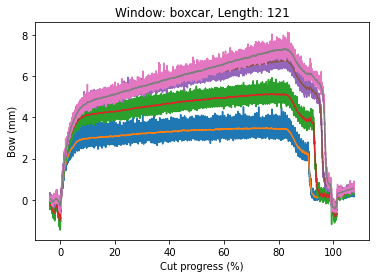

In [24]:
def bow2kappa(data,input_file):
    
    '''
    Data filering and downsampling
    Vertical force computation
    Cutting efficiency kappa computation
    Storage of the results in an excel file with three sheets:
         Bow with columns names:  'Cut progress (%)' 'Bow # (mm)'
         Force with columns names: 'Cut progress (%)' 'Force # (N)'
         Kappa with columns names: 'Cut progress (%)' 'Kappa # x10^7 (m/N)'
    '''

    # Standard library imports
    import os

    # 3rd party imports
    import numpy as np
    import pandas as pd
    from scipy import signal
    import openpyxl
    import matplotlib.pyplot as plt    

    # Excel writer to flush the results
    try:
        with open(output_file):
            os.remove(output_file)
            writer = pd.ExcelWriter(output_file, engine='openpyxl')
    except IOError:        
        writer = pd.ExcelWriter(output_file, engine='openpyxl')

    # conversion time --> cut percentage 
    per_cent_coupe = np.array(data['Time (s)'])
    time_init = per_cent_coupe[0]
    per_cent_coupe = 100 * (per_cent_coupe - time_init - time_to_contact) / (60*cut_effective_duration)

    # Smooth and downsample the data using a moving window of length long and of type win
    long = 121
    win ='boxcar'   #'triang'#'boxcar',  #'hamming', 'boxcar', 
                    #'boxcar','triang', 'blackman', 'hamming', 'bartlett', 'parzen', 'bohman',
    norme = sum(signal.get_window(win, long))
    dic_bow = {}
    bow_name = [x for x in data.columns if 'Bow' in x]
    for bow in bow_name:
        data_filter = data[bow].rolling(long,center=True, win_type=win, axis=0).sum()/norme
        plt.plot(per_cent_coupe,data[bow])
        plt.plot(per_cent_coupe,data_filter)
        dic_bow[bow] = data_filter[long//2+1::long]
    plt.xlabel('Cut progress (%)')
    plt.ylabel('Bow (mm)')
    plt.title(f'Window: {win}, Length: {long}')
    plt.show()
    dic_bow['Cut progress (%)'] = per_cent_coupe[long//2+1::long]
    new = pd.DataFrame.from_dict(dic_bow)
    new=new.reindex(columns= ['Cut progress (%)', *bow_name])

    if os.path.exists(output_file):
            book = openpyxl.load_workbook(output_file)
            writer.book = book
    
    new.to_excel(writer, sheet_name='Bow')
    writer.save()
    writer.close()

    # Vertical force computation
    dic_force = {}
    force_name = [bow.replace('Bow','Force')[:-5] + ' (N)' for bow in bow_name] # Force columns names
    for force,bow in zip(force_name,bow_name):
        dic_force[force] = (4*wire_tension*np.array((dic_bow[bow]))) \
        /(2*wire_guides_gap+brick_width)
    dic_force['Cut progress (%)'] = per_cent_coupe[long//2+1::long]
    new_force = pd.DataFrame.from_dict(dic_force)
    new_force = new_force.reindex(columns= ['Cut progress (%)', *force_name])

    if os.path.exists(output_file):
            book = openpyxl.load_workbook(output_file)
            writer.book = book
    
    new_force.to_excel(writer, sheet_name='Force')
    writer.save()
    writer.close()

    # Cutting efficiency computation
    dic_kappa = {}
    kappa_name = [bow.replace('Bow','Kappa')[:-5] + ' x10^7 (m/N)' for bow in bow_name] # Kappa columns names
    for kappa, force in zip(kappa_name,force_name):  
        dic_kappa[kappa] = 10000000*(brick_width/1000)*table_speed \
        /(wire_speed*np.array((dic_force[force])))
    dic_kappa['Cut progress (%)'] = per_cent_coupe[long//2+1::long]
    new_kappa = pd.DataFrame.from_dict(dic_kappa)
    new_kappa = new_kappa.reindex(columns= ['Cut progress (%)', *kappa_name])

    if os.path.exists(output_file):
            book = openpyxl.load_workbook(output_file)
            writer.book = book
    
    new_kappa.to_excel(writer, sheet_name='Kappa')
    writer.save()
    writer.close()
    
    return dic_bow,dic_force,dic_kappa

# Main for this cell
# Call of bow2kappa function   
_ = bow2kappa(data,input_file)

#  Single 3D plot
The two following cells use the same functions as Kappa3D_Batch:
- Kappa_Wireframe
- Kappa_3Dplot_values
- Kappa_stat
<br>
<br>
Please check the version and use the last one

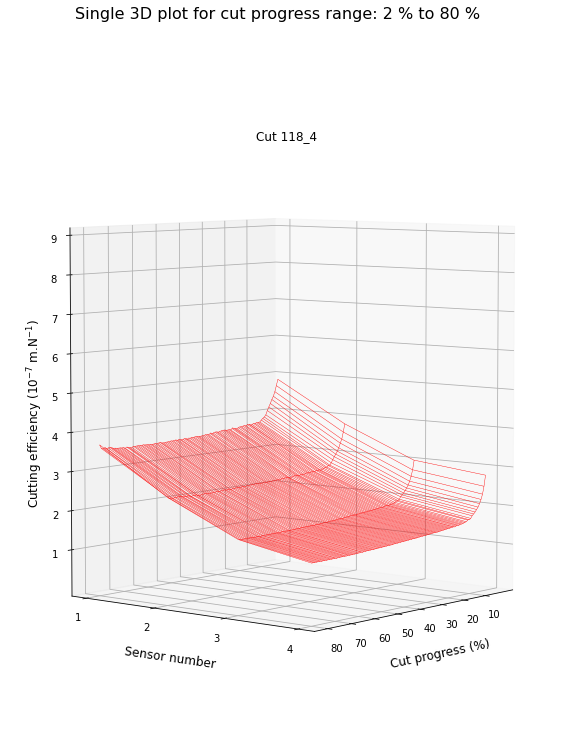

In [8]:
def Kappa_Wireframe(x, y, z, z_min, z_max, sensors_nbr, cut_progress_nb, ax): 

    '''
    Version 2021.02.10
    Wireframe 3D plot configuration of the cutting efficiency values 
    as function of the cut progress and the sensor number
    
    Inputs
    - x:  1D array of the interpolated values of the cut progress for the wireframe 3D plot 
      as arranged by Kappa_3Dplot_values function
    - y:  1D array of the interpolated values of the sensor number for the wireframe 3D plot 
      as arranged by Kappa_3Dplot_values function  
    - z: 2D array of cutting efficiency as arranged by Kappa_3Dplot_values function
    - z_min, z_max: minimum and maximum values of z range 
      used for zaxis in the 3D plot
    - sensors_nbr: number of sensors used for the bow in-situ measurements (parameter of the cut)
    - cut_progress_nb: number of cut progress sampling points (parameter of the cut)
    - ax: figure subplot description
    
    Outputs
    - Wireframe 3D plot configuration of z values 
      as function of x and y 
    '''    

    # 3rd party imports
    import matplotlib.pyplot as plt
    
    # Set plot parameters
    ticks_size = 10  # fontsize of ticks labels 
    label_size = 12  # fontsize of axes labels
    line_space = 2   # line spacing between ticks labels and axe label
    x0 = [10,20,30,40,50,60,70,80]                  # xticklabels
    y0 = [i for i in range(1,sensors_nbr+1)]        # yticklabels 
    z_min_rnd,z_max_rnd,z_step_nbr= int(round(z_min)),int(round(z_max)),1
    z0=[i for i in range(z_min_rnd+1,z_max_rnd+1)]  # yticklabels 
    thickness = 0.4  # Line thickness of the 3D plot curves 
    plot_azim = 40   # 3D plot azimut
    plot_elev = 5    # 3D plot elevation 
    
    # Set a wireframe 3D plot
    surf=ax.plot_wireframe(x, y, z, thickness, rcount=cut_progress_nb, \
                           ccount=sensors_nbr-1, color='red')  
      
    # Set plot title
    ax.set_title(f'Cut {cut_name}', fontsize = label_size) 
    # Set point of view of 3D plot
    ax.view_init(elev=plot_elev, azim=plot_azim)           
    
    # Set x axe   
    ax.set_xticks(x0, minor=False)
    ax.set_xticklabels(x0, fontsize=ticks_size)
    ax.set_xlabel('\nCut progress (%)', linespacing=line_space, fontsize=label_size) 
    
    # Set y axe    
    ax.set_yticks(y0, minor=False)          # set ticks label for y axis (integer values)
    ax.set_yticklabels(y0, fontsize=ticks_size)
    ax.set_ylabel('\nSensor number', linespacing=line_space, fontsize=label_size) 
    
    # Set z axe 
    ax.set_zlim(z_min, z_max)   # set limits of z axis 
    ax.set_zticks(z0, minor=False)
    ax.set_zticklabels(z0, fontsize=ticks_size)    
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel('Cutting efficiency (10$^{-7}$ m.N$^{-1}$)', \
                  rotation=90, fontsize=label_size)  
    

def Kappa_3Dplot_values(output_file,val_min, val_max,z_min,z_max,sensors_nbr): 
    
    '''
    Version 2021.02.10
    Arrangement of the cutting efficiency calculated from the bow in-situ measurements
    by bow2kappa function for a wireframe 3D plot
    
    Inputs
    - output_file: name of the results file (output of bow2kappa function)
    - val_min, val_max : minimum and maximum values of the cut progress range 
      used for data selection and xaxis in the 3D plot
    - z_min, z_max: minimum and maximum values of the cutting efficiency range 
      used for zaxis in the 3D plot
    - sensors_nbr: number of sensors used for the bow in-situ measurements (parameter of the cut)
    
    Outputs
    - 3D plot of the cutting efficiency values 
    '''
    
    # 3rd party imports
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy import interpolate
  
    # Get the cutting efficiency data to plot
    kappa_cols = {
                0: "B",
                1: "C",
                2: "D",
                3: "E",
                4: "F",
                5: "G"    
                }
    endcol=kappa_cols[sensors_nbr+1]
    usecols = 'B:'+ str(endcol)
    dkappa = pd.read_excel(output_file,
                         sheet_name ='Kappa', 
                         usecols=usecols)

    # Select cut progress range and build x,y,z values distribution suitable for the 3D plot
    dkappa.rename({"Cut progress (%)":"A"}, axis=1, inplace=True) # Rename colonne for query attribute use
    df= dkappa.query('A > @val_min and A < @val_max') 
    u = [i for i in range(1,sensors_nbr+1)] # Sensor number 
    v = list(df['A'])                       # % of cut 
    cut_progress_nb= len(v)                 # Number of cut progress values
    df=df.drop(['A'],axis=1)                # Keep only z values in df
    z = df.values                           # 2D array of z values

    # z calculation at interpolated values of u,v  
        # Definition of 2D linear interpolation function
    newfunc = interpolate.interp2d(u,v,z,kind='linear')
        # New sampling of 1000 points along x between extrema of x1
    unew = np.linspace(u[0] , u[-1], num=1000, endpoint=True)
        # New sampling of 1000 points along y between extrema of y1
    vnew = np.linspace(v[0] , v[-1], num=1000, endpoint=True)
        # Use of the defined newfunc as 2D linear interpolation
        # (x,y) mesh re-construction for the (xnew,ynew) positions
    y,x = np.meshgrid(unew, vnew)     
        # for the calculation of z at the (xnew,ynew) positions 
    znew = newfunc(unew, vnew)        

    return x, y, znew, cut_progress_nb
      
# # #    
# Main for this cell
# # #

# 3rd party imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the plot range for the cutting progress in % of cut duration
cut_min, cut_max = 2, 80

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 0, 9

# Set figure parameters
fig = plt.figure(figsize=(10,12))   # Plot area 
gs = gridspec.GridSpec(1, 1)
fig.suptitle(f'Single 3D plot for cut progress range: {cut_min} % to {cut_max} %', fontsize = 16)

# Wireframe 3D plot for the cut
    
# Set x,y,z values for the wireframe 3D plot 
kappa_file_name = 'Results_' +cut_name+'.xlsx'
kappa_file = my_path / kappa_file_name
x,y,z,cut_progress_nb = Kappa_3Dplot_values(kappa_file,cut_min,cut_max,eff_min,eff_max,sensors_nbr)
   
# Plotting the wireframe 3D plot
ax=fig.add_subplot(gs[0,0], projection='3d') # Frame for 3D plot 
Kappa_Wireframe(x, y, z, eff_min, eff_max, sensors_nbr, cut_progress_nb, ax)
    
plt.show()

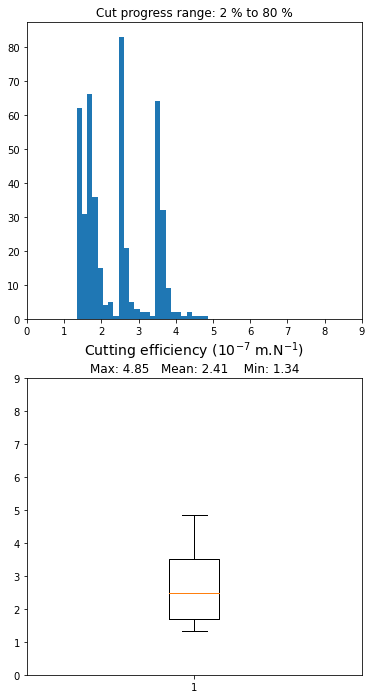

In [9]:
def Kappa_stat(output_file,val_min, val_max,x_min,x_max,sensors_nbr): 
    
    '''
    Version 2021.02.10
    Statistical analysis of the cutting efficiency calculated from the bow in-situ measurements
    by bow2kappa function
    
    Inputs
    - output_file: name of the results file (output of bow2kappa function)
    - val_min, val_max : minimum and maximum values of the cut progress range 
      used for data selection
    - x_min, x_max: minimum and maximum values of the cutting efficiency range 
      used for xaxis in the histogram plot and yaxis in the boxplot
    - sensors_nbr: number of sensors used for the bow in-situ measurements (parameter of the cut)
    
    Outputs
    - Histogram plot of the cutting efficiency values
    - Box plot of the cutting efficiency values
    '''
    
    # 3rd party imports
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt


    # Get the cutting efficiency data to plot
    kappa_cols = {
                0: "B",
                1: "C",
                2: "D",
                3: "E",
                4: "F",
                5: "G"    
                }
    endcol=kappa_cols[sensors_nbr+1]
    usecols = 'B:'+ str(endcol)
    dkappa = pd.read_excel(output_file,
                         sheet_name ='Kappa', 
                         usecols=usecols)
    
    # Select cut progress range
    dkappa.rename({"Cut progress (%)":"A"}, axis=1, inplace=True)
    df = dkappa.query('A > @val_min and A < @val_max') 
    df = df.drop(['A'],axis=1)
    
    # Statistics computation
    df_flatten = df.values.flatten()
    k_mean = "{:5.2f}".format(np.mean(df_flatten)) 
    k_max = "{:5.2f}".format(np.max(df_flatten)) 
    k_min = "{:5.2f}".format(np.min(df_flatten)) 
    
    # Statistics plot
    fig = plt.figure(figsize=(6,12))
    plt.subplot(2,1,1)
    plt.hist(df_flatten,bins=25)
    plt.xlim(x_min,x_max)
    plt.xlabel('Cutting efficiency (10$^{-7}$ m.N$^{-1}$)',fontsize=14)  
    plt.title(f'Cut progress range: {val_min} % to {val_max} %')
    
    plt.subplot(2,1,2)
    plt.boxplot(df_flatten)
    plt.ylim(x_min,x_max)
    plt.title(f'Max:{k_max}   Mean:{k_mean}    Min:{k_min}')
    
    plt.show()
    

# Main for this cell   
# Set the plot range for the cutting progress in % of cut duration
cut_min = 2
cut_max = 80

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min = 0
eff_max = 9

# call Kappa_stat function
Kappa_stat(output_file,cut_min, cut_max,eff_min,eff_max,sensors_nbr)    